# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment! Please ensure the ```file_name``` points to the ```Tennis.exe``` application on your machine.

In [2]:
env = UnityEnvironment(file_name="./../tennis-windows/Tennis.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### Multi-Agent PPO

In [5]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [6]:
from MultiAgent import MultiAgent

from tqdm.auto import tqdm
import matplotlib.pyplot as plt

In [7]:
n_episodes = 10000
reward_threshold = 0.5
update_every = 20

ma = MultiAgent(state_size, action_size, num_agents, hidden_size=200)

In [8]:
total_score = []

episodes_bar = tqdm(total=n_episodes, desc='Episodes')
for i_episode in range(n_episodes):
   # Reset environment and get initial state
   env_info = env.reset(train_mode=True)[brain_name]
   states = env_info.vector_observations
   dones = env_info.local_done
   scores = np.zeros(num_agents)
   
   while not any(dones):
      # Choose actions based on policy
      actions, log_probs, values = ma.act(states)
      
      # Take the chosen action and register environment reaction
      env_info = env.step(np.clip(actions, -1, 1))[brain_name]
      next_states = env_info.vector_observations
      dones = env_info.local_done
      rewards = env_info.rewards
      
      # Register the environment response
      ma.step(states, actions, rewards, dones, log_probs, values)
      
      # Update state and keep track of total scores per episode
      scores += rewards
      states = next_states

   # Keep track of scores collected per episode
   total_score.append(max(scores))
   
   # Get final value from terminal state
   _, _, terminal_values = ma.act(states)
   ma.step(states, None, None, None, None, terminal_values, is_terminal=True)

   # Calculate advantages via Generalized Advantage Estimation
   ma.process_trajectories(gamma=0.99, gae_tau=0.95)
   
   # learn policy from collected trajectories, but only if enough experiences were collected
   ma.maybe_learn(i_episode+1, update_every=update_every)
      
   # Calculate average score and print stats
   average_score = np.mean(total_score[-100:])
   if i_episode % 100 == 0:
      print(f'Episode {i_episode}/{n_episodes} | Average Score: {round(average_score, 2)}')
   if average_score >= reward_threshold:
      print(f'Environment solved in {i_episode}!')
      ma.save_checkpoint()
      break
      
   episodes_bar.update(1)
episodes_bar.close()

Episode 0/10000 | Average Score: 0.0
Episode 100/10000 | Average Score: 0.02
Episode 200/10000 | Average Score: 0.01
Episode 300/10000 | Average Score: 0.02
Episode 400/10000 | Average Score: 0.01
Episode 500/10000 | Average Score: 0.03
Episode 600/10000 | Average Score: 0.02
Episode 700/10000 | Average Score: 0.03
Episode 800/10000 | Average Score: 0.04
Episode 900/10000 | Average Score: 0.05
Episode 1000/10000 | Average Score: 0.03
Episode 1100/10000 | Average Score: 0.04
Episode 1200/10000 | Average Score: 0.05
Episode 1300/10000 | Average Score: 0.05
Episode 1400/10000 | Average Score: 0.06
Episode 1500/10000 | Average Score: 0.04
Episode 1600/10000 | Average Score: 0.05
Episode 1700/10000 | Average Score: 0.06
Episode 1800/10000 | Average Score: 0.07
Episode 1900/10000 | Average Score: 0.07
Episode 2000/10000 | Average Score: 0.06
Episode 2100/10000 | Average Score: 0.07
Episode 2200/10000 | Average Score: 0.08
Episode 2300/10000 | Average Score: 0.08
Episode 2400/10000 | Average 

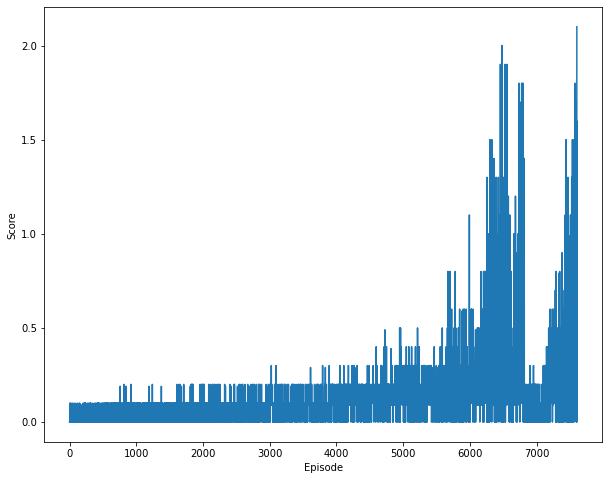

In [9]:
plt.figure(figsize=(10, 8))
plt.plot(total_score, label='PPO')
plt.xlabel('Episode')
plt.ylabel('Score')
plt.show()

# Test Agent

In [ ]:
ma = MultiAgent(state_size, action_size, num_agents, hidden_size=200)
ma.load_checkpoint('./checkpoint.pth')

In [16]:
env_info = env.reset(train_mode=False)[brain_name]
states = env_info.vector_observations
dones = env_info.local_done
scores = np.zeros(num_agents)

n_steps = 100
t_step = 0
while (not any(dones)) or (t_step < n_steps):
   # Get optimal action
   actions, _, _ = ma.act(states)
   
   # Take the chosen action and register environment reaction
   env_info = env.step(np.clip(actions, -1, 1))[brain_name]
   next_states = env_info.vector_observations
   dones = env_info.local_done
   rewards = env_info.rewards
   
   # Update state and keep track of total scores per episode
   scores += rewards
   states = next_states

   t_step += 1

print('Total score for this game is: {}'.format(max(scores)))

Total score for this game is: 1.5000000223517418


# Close Environment

In [17]:
env.close()